In [7]:
%load_ext autoreload
%autoreload 2

# Task 3: Eigenfaces & Fischerfaces (3 pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   Nazar Andrushko
*   Roman Kovalchuk


In this task your main goal is to discuss dimensionality reduction techniques, such as **PCA** and **LDA** and their performance on classification tasks.

A good source to read more on these methods is the book

*   Kevin P. Murphy. [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html), MIT, 2022. Section 9.2.6 (FLDA), 20.1 (PCA and Eigenfaces)



## 1. Lib and Data prep (0.5 pts)
#### Let's start with importing all neccesary libraries and preparing our data

In [1]:
from PIL import Image
from sklearn.datasets import fetch_lfw_people
import numpy as np
from sklearn.svm import SVC
import sklearn
from matplotlib import pyplot as plt
import scipy

Seed libs, so we get the same results every time:

In [2]:
sklearn.random.seed(1)
np.random.seed(1)

Fetch data and split them into training and test sets:

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.3)
n,h,w = lfw_people.images.shape
labels = lfw_people.target

class1, class2 = 1,3 # choose your preferred classes, make sure that there is almost equal number of samples for each class

x= lfw_people.data[(labels == class1)|(labels==class2)]
y = labels[(labels == class2)|(labels==class1)]

x_train, x_test, y_train, y_test =  train_test_split(x,y)# split data using sklearn library
x_train.shape, x_test.shape

((172, 1036), (58, 1036))

In [5]:
print( "Percent of class1 in the dataset : ", (y == class1).sum()/len(y))

Percent of class1 in the dataset :  0.5260869565217391


Visualise Your data:

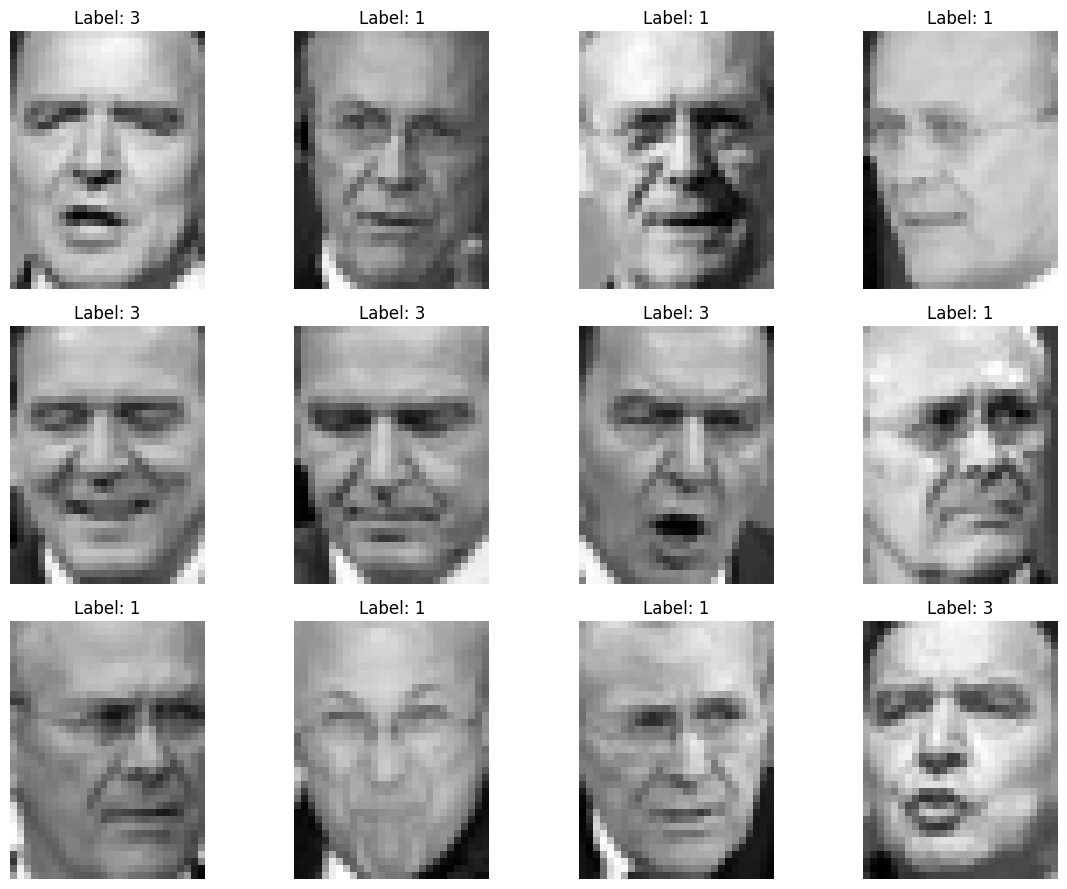

In [6]:
# ========= YOUR CODE STARTS HERE ========= #
from matplotlib import pyplot as plt
# Define the number of rows and columns in the grid
rows, cols = 3, 4  # Adjust as needed

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Display images with labels in the grid
for i in range(rows * cols):
    axes[i].imshow(x[i].reshape((37,28)), cmap='gray')  # Assuming the images are grayscale
    axes[i].set_title(f'Label: {y[i]}')
    axes[i].axis('off')  # Turn off axis labels

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
# ========== YOUR CODE ENDS HERE ========== #

## 2. PCA (1.5 pts)


### **2.1 (0.7 pt) Implementation**
Let's start implementing the **PCA** algorithm

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class MYPCA:
    def __init__(self) -> None:
        pass

    def _get_num_components(self, lambdas, threshold) -> int:
        """
        Calculate minimal number of principal components so that variance explainability >= threshold.
        """
        cumulative_variance = np.cumsum(lambdas) / np.sum(lambdas)
        num_components = np.argmax(cumulative_variance >= threshold) + 1
        return num_components

    def center_data(self, data):
        """
        Center our data by subtracting the mean
        """
        self._data_mean = np.mean(data, axis=0)
        centered_data = data - self._data_mean
        return centered_data

    def compute_eigen(self, cov_mat):
        """
        Using built-in numpy functionality, compute eigenvectors and eigenvalues of covariance matrix;
        """
        eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
        # Ensure the eigenvectors are sorted in descending order of eigenvalues
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        return eigenvalues, eigenvectors

    def fit(self, data, exp_threshold=0.8):
        """
        1. Center the data;
        2. Compute covariance matrix
        3. Compute optimal k (number of components)
        4. Compute top-k eigenvalues from covariance matrix
        5. Compute components by projecting data with eigenvectors
        """ 
        data_norm = self.center_data(data)
        cov_mat = np.cov(data_norm, rowvar=False)
        self.eigenvalues, self.eigenvectors = self.compute_eigen(cov_mat=cov_mat)

        self._k_components = self._get_num_components(self.eigenvalues, exp_threshold)
        top_k_vectors = self.eigenvectors[:, :self._k_components]
        self.top_k_vectors = top_k_vectors
        self.components = top_k_vectors.T.dot(data_norm.T).T

    def plot_components(self, im_shape, n_visualize=1):
        """
        For better understanding, visualize the *self.components* variable.
        """
        # Reshape components back to the original image shape
        plt.figure(figsize=(50, 8))
        visualized_vectors_n = min(self._k_components,n_visualize)
        for i in range(visualized_vectors_n):
            plt.subplot(1, self._k_components, i + 1)
            plt.imshow(self.top_k_vectors[:, i].reshape(im_shape), cmap='gray')
            plt.title(f'Eigen vector {i + 1}')
            plt.axis('off')

    def plot_explainability(self,n_components=100):
        """
        Plot dependence of variance explainability on the number of components.
        """
        cumulative_variance = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)
        plt.plot(np.arange(1, len(cumulative_variance) + 1)[:n_components], cumulative_variance[:n_components], marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance Explained')
        plt.title('Variance Explained vs. Number of Components')
        plt.grid(True)
        plt.show()

    def transform(self, data):
        """
        1. Center the data;
        2. Projection onto the components
        """
        data_norm = self.center_data(data)
        return data_norm.dot(self.eigenvectors[:, :self._k_components])


### **2.2 PCA Classifier (0.4 pts)**
Having implemented the **MYPCA** class, let's plot how our components look like and our explainability plot

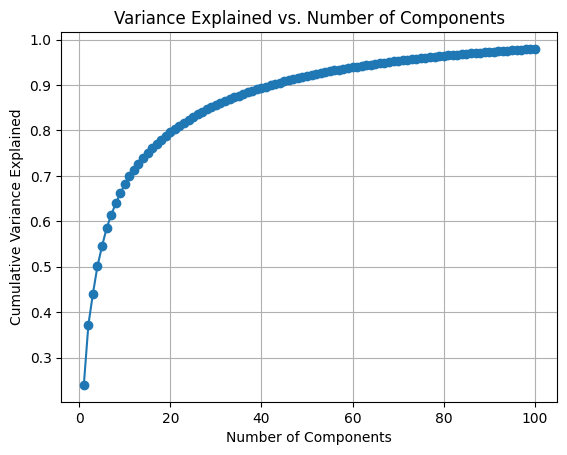

In [8]:
pca = MYPCA()
pca.fit(x_train, exp_threshold=0.8)
pca.plot_explainability(n_components=100)

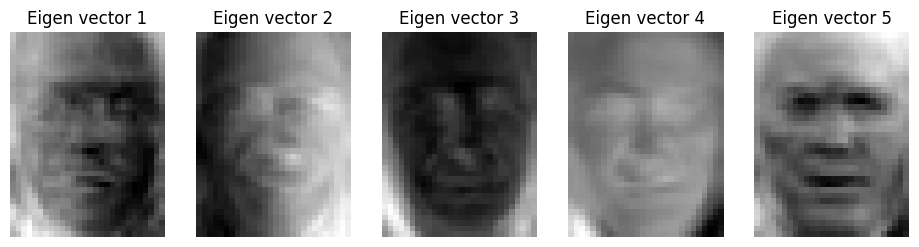

In [9]:
pca.plot_components(im_shape=(37,28),n_visualize=5)

Now, let's try to classify the data, using sklearn **SVC**.

In [10]:
classifier = SVC().fit(pca.transform(x_train), y_train)
print(classifier.score(pca.transform(x_test), y_test))

0.9137931034482759


### **2.3. Discussion of the results (0.4 pts):**
1. What is the concept of variance explainability and why is it so important?

1. What is the optimal number of components to reach good enough classification performance and why?


---
#### **Your answer here:**

**Variance Explainability:**

   Understanding variance helps figure out what factors are important in a model. It helps decide which features matter the most. This is crucial when, for instance, we have a lot of features and we need to pick only the best one. Understanding this concept and utilizing it correctly helps us to reduce the complexity of the model when keeping the metrics (accuracy, f1, etc.) almost on the same level. 



**Optimal Components for Classification:**

   When selecting optimal number of components we have again have a trade-off between complexity of model and accuracy. From the plot with number of components and variance explainability we can see that when we reach 100 number of components we achieve almost 100% explainability, so if we really need to have precise classification we would like to use 100 components or even more. However if accuracy is not that important for us, and we might decrease number of components approximately to 50-60, to have less complex model.
   
---

## 3. Fischerface classification and LDA (1 pt)
Now, having implemented the **PCA** algorithm, let's implement the **Linear Discriminant Analysis** algorithm.

By this [link](https://towardsdatascience.com/fishers-linear-discriminant-intuitively-explained-52a1ba79e1bb) you can read more about this algorithm.

In this task we will see how we can improve our classification using **LDA**.

### **3.1. (0.6 pt) Implementation**
Here you only need to compute the $\mathbf{\it{S_B}}$ and $\mathbf{\it{S_W}}$ covariance matrices, discussed in the source above, and select appropriate eigenvectors

In [11]:
import numpy as np
import scipy.linalg

class MYLDA:
    def fit(self, data, data_labels, k_components):
        n_feats = data.shape[-1]
        SW = np.zeros((n_feats, n_feats))
        SB = np.zeros((n_feats, n_feats))
        mu = data.mean(0)

        # ========= YOUR CODE STARTS HERE ========= #
        
        # Calculate within-class scatter matrix (SW) and between-class scatter matrix (SB)
        for channel in np.unique(data_labels):
            # Get samples for the current class
            class_samples = data[data_labels == channel]
            class_mean = class_samples.mean(0)
            class_SW = (class_samples - class_mean).T @ (class_samples - class_mean)
            SW += class_SW
            
            # Calculate between-class scatter matrix
            n_samples_in_class = len(class_samples)
            SB += n_samples_in_class * (class_mean - mu).reshape(-1, 1) @ (class_mean - mu).reshape(1, -1)

        # ========== YOUR CODE ENDS HERE ========== #

        # Solve the generalized eigenvalue problem
        evals, evecs = scipy.linalg.eigh(SB, SW)

        # Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(evals)[::-1]
        evecs = evecs[:, sorted_indices]

        # Select the top k eigenvectors
        self.proj = evecs[:, :k_components]

    def transform(self, data):
        return data @ self.proj


Here we will implement the class for the Fischerface algorithm, which basically uses an **LDA** on top of **PCA**, such that we will perform maximum dimensionality reduction for classification purposes:

In [12]:
class FischerFaces:
    def __init__(self) -> None:
        """
        Initialize pca and lda
        """
        self.pca = MYPCA()
        self.lda = MYLDA()

    def fit(self, X, Y, threshold, lda_components):
        """
        Fit the Fischerface algorithm:
        1. Fit PCA
        2. Reduce data dimensions with PCA
        3. Fit LDA
        """
        self.pca.fit(X, exp_threshold=threshold)
        pca_trans = self.pca.transform(X)
        self.lda.fit(pca_trans, Y, lda_components)

    def transform(self, X):
        """
        Transform the data by using fitted PCA and LDA
        """
        pca_trans = self.pca.transform(X)
        return self.lda.transform(pca_trans)


Now, let's try out our new classifier based on Fischerface algorithm.

*Hint*: select the number of LDA components equal to the number of classes

In [13]:
f = FischerFaces()
f.fit(x_train, y_train, threshold=0.8, lda_components=2)

classifier = SVC().fit(f.transform(x_train), y_train)
print(classifier.score(f.transform(x_test), y_test))

0.896551724137931


In [14]:
f = FischerFaces()
f.fit(x_train, y_train, threshold=0.8, lda_components=5)

classifier = SVC().fit(f.transform(x_train), y_train)
print(classifier.score(f.transform(x_test), y_test))

0.9310344827586207


### **2.2 Discussion (0.4 pts)**
Evaluate the results of Fishcerface classifier (LDA). Discuss whether it performs better than the classic Eigenface algorithm (PCA), and if so, why

---
#### **Your explanations come here**

When we select number of components to be equal to 2, Fishcerface classifer performs worse than Eigenface.

When number of components is increased to 5 we see that Fishcerface outperforms Eigenface.

The better accuracy with Fisherfaces could be because it's good at making different classes more distinct when reducing dimensions. In comparison, PCA mainly focuses on capturing the overall variability in the data without paying attention to class labels, however it is still important to note that overall performance depends on parameters that we choose.

---